# Performance on test sets

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm import tqdm, tnrange

In [3]:
#%% Define the network architecture
class Autoencoder(nn.Module):
    def __init__(self, encoded_space_dim, dropout=0.2):
        super().__init__()
        
        ### Encoder
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 64),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(64, encoded_space_dim)
        )
        
        ### Decoder
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.Linear(64, 3 * 3 * 32),
            nn.ReLU(True),
            nn.Dropout(dropout)
        )
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout(dropout),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = x.view([x.size(0), -1])
        # Apply linear layers
        x = self.encoder_lin(x)
        return x
    
    def decode(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Reshape
        x = x.view([-1, 32, 3, 3])
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [11]:
### Testing function
def test_net_v0(net, dataloader, loss_fn):

    # select device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        batch_len = np.zeros(len(dataloader))
        batch_loss = np.zeros(len(dataloader))
        for i, sample_batch in enumerate(dataloader,0):
            # Extract data and move tensors to the selected device
            image_batch = sample_batch[0].to(device)
            # Forward pass
            out = net(image_batch)
            
            # Evaluate global loss
            loss = loss_fn(out, image_batch)
            
            # save MSE loss and length of a batch
            batch_len[i] = len(sample_batch[0])
            batch_loss[i] = loss.item()
    
    # total MSE loss
    val_loss = (batch_loss*batch_len).sum()/batch_len.sum()
    return val_loss

## Uncorrupted inputs and outputs for different encoded dimensions

In [7]:
#%% Define paths

data_root_dir = '../datasets'

#%% Create dataset

test_transform = transforms.Compose([
    transforms.ToTensor(),
])

test_dataset  = MNIST(data_root_dir, train=False, download=False, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [5]:
encoded_space_dims = [1,2,4,8,16]
best_model_dict = np.load('best_model_dict.npy', allow_pickle=True).item()

In [13]:
loss_fn = nn.MSELoss()
test_losses = []
for encoded_space_dim in encoded_space_dims:
    # init autoencoder
    net = Autoencoder(encoded_space_dim, best_model_dict['dropout'])
    # load trained weights
    net.load_state_dict(torch.load('params/net_params_'+str(encoded_space_dim)+'.pth', 
                                   map_location=torch.device('cpu')))
    # test autoencoder
    test_loss = test_net_v0(net, test_loader, loss_fn)
    print("Encoded space dim: %d - loss : %.4f "%(encoded_space_dim,test_loss))
    test_losses.append(test_loss)
np.save('Analysis_results/test_losses', test_losses)

Encoded space dim: 1 - loss : 0.0525 
Encoded space dim: 2 - loss : 0.0436 
Encoded space dim: 4 - loss : 0.0317 
Encoded space dim: 8 - loss : 0.0228 
Encoded space dim: 16 - loss : 0.0184 


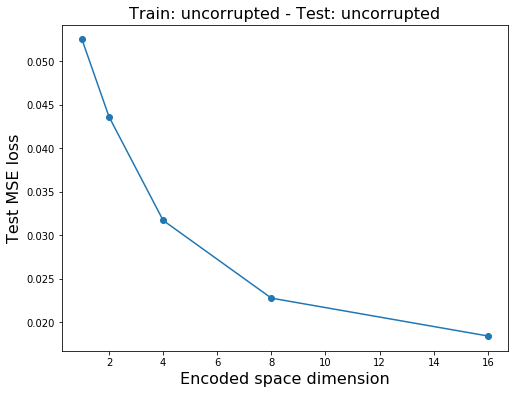

In [23]:
plt.figure(figsize=(8,6))
plt.plot(encoded_space_dims, test_losses, 'o-')
plt.xlabel("Encoded space dimension", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: uncorrupted - Test: uncorrupted", fontsize=16)
plt.show()

## Using noisy inputs but clean output targets
Idea: create a new dataset with each element given by (x_noisy, x_original)

In [24]:
class NoisyDataset(Dataset):
    def __init__(self, dataset1, dataset2):
        
        assert len(dataset1) == len(dataset2), "Datasets should have the same length"
        data = []
        target = []
        labels = []
        s = dataset1[0][0].shape
        for i in range(len(dataset1)):
            data.append(dataset1[i][0])
            target.append(dataset2[i][0])
            #labels.append(dataset1[i][1])
        self.data = torch.cat(data).view((-1,)+s)
        self.target = torch.cat(target).view((-1,)+s)
        #self.labels = torch.LongTensor(labels)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return (self.data[index], self.target[index])#, self.labels[index])

As for training we need a new test function.

In [25]:
### Testing function
def test_denoisingAE(net, dataloader, loss_fn):

    # select device
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
        
    # Validation
    net.eval() # Evaluation mode (e.g. disable dropout)
    with torch.no_grad(): # No need to track the gradients
        batch_len = np.zeros(len(dataloader))
        batch_loss = np.zeros(len(dataloader))
        for i, sample_batch in enumerate(dataloader,0):
            # Extract data and move tensors to the selected device
            data = sample_batch[0].to(device)
            target = sample_batch[1].to(device)
            # Forward pass
            out = net(data)
            
            # Evaluate global loss
            loss = loss_fn(out, target)
            
            # save MSE loss and length of a batch
            batch_len[i] = len(sample_batch[0])
            batch_loss[i] = loss.item()
    
    # total MSE loss
    val_loss = (batch_loss*batch_len).sum()/batch_len.sum()
    return val_loss

## Systematic analysis on gaussian noise intensity

In [31]:
# define loss
loss_fn = nn.MSELoss()
# define values of sigma to be tested
sigmas = np.linspace(0.01,0.5,20)

gaussian_test_losses = []
for encoded_space_dim in encoded_space_dims:
    print("Testing encoded space dim: %d"%encoded_space_dim)
    gaussian_losses = []
        
    # init autoencoder
    net = Autoencoder(encoded_space_dim, best_model_dict['dropout'])
    # load trained weights
    net.load_state_dict(torch.load('params/net_params_'+str(encoded_space_dim)+'.pth', 
                                   map_location=torch.device('cpu')))
    
    for sigma in sigmas:
        print('\r'+"Testing gaussian noising with sigma %.3f"%sigma, end=' ')

        # define/update gaussian transform with new sigma
        gaussian_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x+np.random.normal(scale=sigma,size=x.shape)).float()),
        ])

        # load dataset and apply noise to it 
        gaussian_test_dataset = MNIST(data_root_dir, train=False, download=False, transform=gaussian_test_transform)
        # merge it with the original dataset that will be used as target
        gaussian_test_dataset = NoisyDataset(gaussian_test_dataset, test_dataset)
        # create test set loader to stream the data in batches to the net
        test_loader = DataLoader(gaussian_test_dataset, batch_size=512, shuffle=False)
        # compute the test loss
        gaussian_test_loss = test_denoisingAE(net, test_loader, nn.MSELoss())
        print('\r'+"Testing gaussian noising with sigma %.3f - loss : %.4f"%(sigma, gaussian_test_loss))
        gaussian_losses.append(gaussian_test_loss)
    gaussian_test_losses.append(gaussian_losses)
    
gaussian_test_losses = np.array(gaussian_test_losses)
np.save("Analysis_results/gaussian_losses", gaussian_test_losses)
np.save("Analysis_results/sigmas", sigmas)

Testing encoded space dim: 1
Testing gaussian noising with sigma 0.010 - loss : 0.0525
Testing gaussian noising with sigma 0.036 - loss : 0.0525
Testing gaussian noising with sigma 0.062 - loss : 0.0525
Testing gaussian noising with sigma 0.087 - loss : 0.0525
Testing gaussian noising with sigma 0.113 - loss : 0.0525
Testing gaussian noising with sigma 0.139 - loss : 0.0526
Testing gaussian noising with sigma 0.165 - loss : 0.0526
Testing gaussian noising with sigma 0.191 - loss : 0.0528
Testing gaussian noising with sigma 0.216 - loss : 0.0529
Testing gaussian noising with sigma 0.242 - loss : 0.0531
Testing gaussian noising with sigma 0.268 - loss : 0.0532
Testing gaussian noising with sigma 0.294 - loss : 0.0535
Testing gaussian noising with sigma 0.319 - loss : 0.0537
Testing gaussian noising with sigma 0.345 - loss : 0.0539
Testing gaussian noising with sigma 0.371 - loss : 0.0542
Testing gaussian noising with sigma 0.397 - loss : 0.0545
Testing gaussian noising with sigma 0.423 -

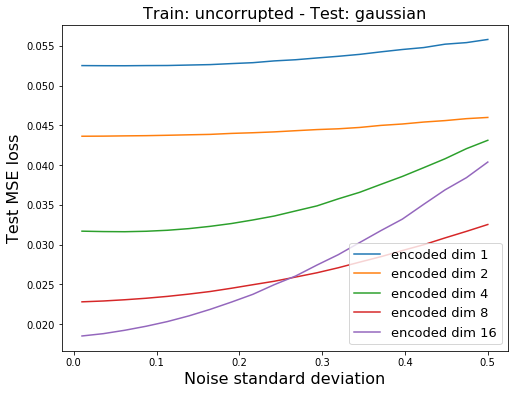

In [34]:
plt.figure(figsize=(8,6))
for i in range(len(gaussian_test_losses)):
    plt.plot(sigmas,gaussian_test_losses[i,:], label='encoded dim %d'%(2**i))
plt.legend(fontsize=13)
plt.xlabel("Noise standard deviation", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: uncorrupted - Test: gaussian", fontsize=16)
plt.show()

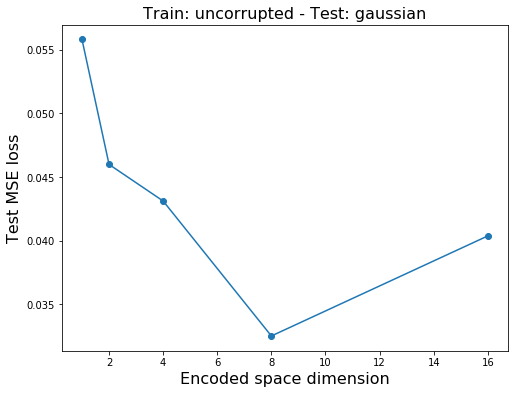

In [38]:
plt.figure(figsize=(8,6))
plt.plot(encoded_space_dims,gaussian_test_losses[:,-1], '-o')
plt.xlabel("Encoded space dimension", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: uncorrupted - Test: gaussian", fontsize=16)
plt.show()

## Systematic analysis on scale of occlusion

In [36]:
# define loss
loss_fn = nn.MSELoss()
# define values of sigma to be tested
scales = np.linspace(0.01,0.5,20)

occluded_test_losses = []
for encoded_space_dim in encoded_space_dims:
    print("Testing encoded space dim: %d"%encoded_space_dim)
    occluded_losses = []
        
    # init autoencoder
    net = Autoencoder(encoded_space_dim, best_model_dict['dropout'])
    # load trained weights
    net.load_state_dict(torch.load('params/net_params_'+str(encoded_space_dim)+'.pth', 
                                   map_location=torch.device('cpu')))
    
    for scale in scales:
        print('\r'+"Testing occlusion noise with scale %.3f"%scale, end=' ')

        # define/update gaussian transform with new sigma
        occluded_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(scale, scale), ratio=(1,1), value=np.random.rand()),
        ])

        # load dataset and apply noise to it 
        occluded_test_dataset = MNIST(data_root_dir, train=False, download=False, transform=occluded_test_transform)
        # merge it with the original dataset that will be used as target
        occluded_test_dataset = NoisyDataset(occluded_test_dataset, test_dataset)
        # create test set loader to stream the data in batches to the net
        test_loader = DataLoader(occluded_test_dataset, batch_size=512, shuffle=False)
        # compute the test loss
        occluded_test_loss = test_denoisingAE(net, test_loader, nn.MSELoss())
        print('\r'+"Testing occlusion noise with scale %.3f - loss : %.4f"%(scale, occluded_test_loss))
        occluded_losses.append(occluded_test_loss)
    occluded_test_losses.append(occluded_losses)
    
occluded_test_losses = np.array(occluded_test_losses)
np.save("Analysis_results/occluded_losses", occluded_test_losses)
np.save("Analysis_results/scales", scales)

Testing encoded space dim: 1
Testing occlusion noise with scale 0.010 - loss : 0.0525
Testing occlusion noise with scale 0.036 - loss : 0.0535
Testing occlusion noise with scale 0.062 - loss : 0.0562
Testing occlusion noise with scale 0.087 - loss : 0.0569
Testing occlusion noise with scale 0.113 - loss : 0.0546
Testing occlusion noise with scale 0.139 - loss : 0.0553
Testing occlusion noise with scale 0.165 - loss : 0.0605
Testing occlusion noise with scale 0.191 - loss : 0.0608
Testing occlusion noise with scale 0.216 - loss : 0.0648
Testing occlusion noise with scale 0.242 - loss : 0.0606
Testing occlusion noise with scale 0.268 - loss : 0.0642
Testing occlusion noise with scale 0.294 - loss : 0.0686
Testing occlusion noise with scale 0.319 - loss : 0.0684
Testing occlusion noise with scale 0.345 - loss : 0.0675
Testing occlusion noise with scale 0.371 - loss : 0.0666
Testing occlusion noise with scale 0.397 - loss : 0.0724
Testing occlusion noise with scale 0.423 - loss : 0.0704
Te

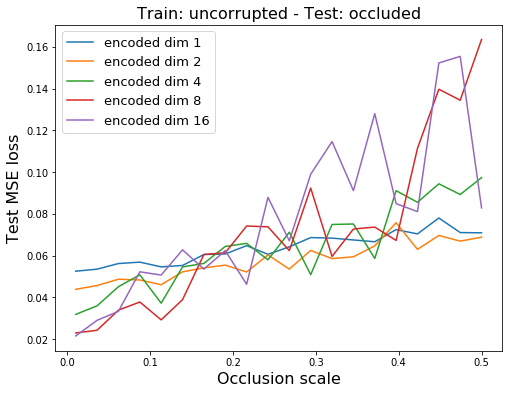

In [39]:
plt.figure(figsize=(8,6))
for i in range(len(occluded_test_losses)):
    plt.plot(scales,occluded_test_losses[i,:], label='encoded dim %d'%(2**i))
plt.legend(fontsize=13)
plt.xlabel("Occlusion scale", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: uncorrupted - Test: occluded", fontsize=16)
plt.show()

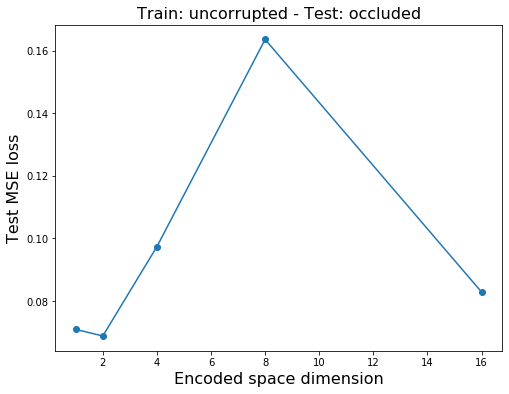

In [40]:
plt.figure(figsize=(8,6))
plt.plot(encoded_space_dims, occluded_test_losses[:,-1], '-o')
plt.xlabel("Encoded space dimension", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: uncorrupted - Test: occluded", fontsize=16)
plt.show()

# Optional part: denoising autoencoders
I know repeat the analysis on the corrupted test sets using 2 different kind of models: those trained on reconstructing images corrupted with gaussian noise and those trained on doing the same for occluded images.

## Train: gaussian - Test: gaussian

In [41]:
# define loss
loss_fn = nn.MSELoss()
# define values of sigma to be tested
sigmas = np.linspace(0.01,0.5,20)

GG_test_losses = []
for encoded_space_dim in encoded_space_dims:
    print("Testing encoded space dim: %d"%encoded_space_dim)
    gaussian_losses = []
        
    # init autoencoder
    net = Autoencoder(encoded_space_dim, best_model_dict['dropout'])
    # load trained weights
    net.load_state_dict(torch.load('params/gaussian_net_params_'+str(encoded_space_dim)+'.pth', 
                                   map_location=torch.device('cpu')))
    
    for sigma in sigmas:
        print('\r'+"Testing gaussian noising with sigma %.3f"%sigma, end=' ')

        # define/update gaussian transform with new sigma
        gaussian_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x+np.random.normal(scale=sigma,size=x.shape)).float()),
        ])

        # load dataset and apply noise to it 
        gaussian_test_dataset = MNIST(data_root_dir, train=False, download=False, transform=gaussian_test_transform)
        # merge it with the original dataset that will be used as target
        gaussian_test_dataset = NoisyDataset(gaussian_test_dataset, test_dataset)
        # create test set loader to stream the data in batches to the net
        test_loader = DataLoader(gaussian_test_dataset, batch_size=512, shuffle=False)
        # compute the test loss
        gaussian_test_loss = test_denoisingAE(net, test_loader, nn.MSELoss())
        print('\r'+"Testing gaussian noising with sigma %.3f - loss : %.4f"%(sigma, gaussian_test_loss))
        gaussian_losses.append(gaussian_test_loss)
    GG_test_losses.append(gaussian_losses)
    
GG_test_losses = np.array(GG_test_losses)
np.save("Analysis_results/GG_losses", GG_test_losses)
np.save("Analysis_results/sigmas", sigmas)

Testing encoded space dim: 1
Testing gaussian noising with sigma 0.010 - loss : 0.0529
Testing gaussian noising with sigma 0.036 - loss : 0.0529
Testing gaussian noising with sigma 0.062 - loss : 0.0530
Testing gaussian noising with sigma 0.087 - loss : 0.0530
Testing gaussian noising with sigma 0.113 - loss : 0.0532
Testing gaussian noising with sigma 0.139 - loss : 0.0532
Testing gaussian noising with sigma 0.165 - loss : 0.0534
Testing gaussian noising with sigma 0.191 - loss : 0.0535
Testing gaussian noising with sigma 0.216 - loss : 0.0537
Testing gaussian noising with sigma 0.242 - loss : 0.0540
Testing gaussian noising with sigma 0.268 - loss : 0.0542
Testing gaussian noising with sigma 0.294 - loss : 0.0545
Testing gaussian noising with sigma 0.319 - loss : 0.0548
Testing gaussian noising with sigma 0.345 - loss : 0.0551
Testing gaussian noising with sigma 0.371 - loss : 0.0555
Testing gaussian noising with sigma 0.397 - loss : 0.0557
Testing gaussian noising with sigma 0.423 -

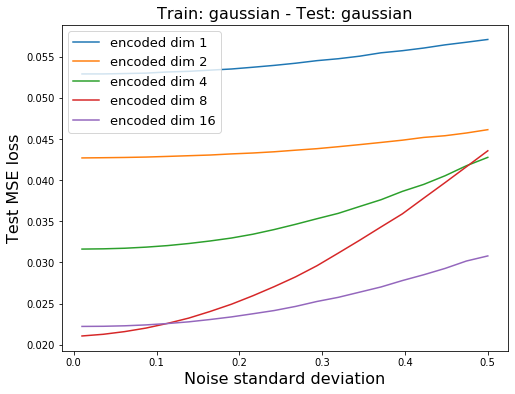

In [42]:
plt.figure(figsize=(8,6))
for i in range(len(GG_test_losses)):
    plt.plot(sigmas,GG_test_losses[i,:], label='encoded dim %d'%(2**i))
plt.legend(fontsize=13)
plt.xlabel("Noise standard deviation", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: gaussian - Test: gaussian", fontsize=16)
plt.show()

## Train: gaussian - Test: occluded

In [44]:
# define loss
loss_fn = nn.MSELoss()
# define values of sigma to be tested
scales = np.linspace(0.01,0.5,20)

GO_test_losses = []
for encoded_space_dim in encoded_space_dims:
    print("Testing encoded space dim: %d"%encoded_space_dim)
    occluded_losses = []
        
    # init autoencoder
    net = Autoencoder(encoded_space_dim, best_model_dict['dropout'])
    # load trained weights
    net.load_state_dict(torch.load('params/gaussian_net_params_'+str(encoded_space_dim)+'.pth', 
                                   map_location=torch.device('cpu')))
    
    for scale in scales:
        print('\r'+"Testing occlusion noise with scale %.3f"%scale, end=' ')

        # define/update gaussian transform with new sigma
        occluded_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(scale, scale), ratio=(1,1), value=np.random.rand()),
        ])

        # load dataset and apply noise to it 
        occluded_test_dataset = MNIST(data_root_dir, train=False, download=False, transform=occluded_test_transform)
        # merge it with the original dataset that will be used as target
        occluded_test_dataset = NoisyDataset(occluded_test_dataset, test_dataset)
        # create test set loader to stream the data in batches to the net
        test_loader = DataLoader(occluded_test_dataset, batch_size=512, shuffle=False)
        # compute the test loss
        occluded_test_loss = test_denoisingAE(net, test_loader, nn.MSELoss())
        print('\r'+"Testing occlusion noise with scale %.3f - loss : %.4f"%(scale, occluded_test_loss))
        occluded_losses.append(occluded_test_loss)
    GO_test_losses.append(occluded_losses)
    
GO_test_losses = np.array(GO_test_losses)
np.save("Analysis_results/GO_losses", GO_test_losses)
np.save("Analysis_results/scales", scales)

Testing encoded space dim: 1
Testing occlusion noise with scale 0.010 - loss : 0.0533
Testing occlusion noise with scale 0.036 - loss : 0.0541
Testing occlusion noise with scale 0.062 - loss : 0.0550
Testing occlusion noise with scale 0.087 - loss : 0.0545
Testing occlusion noise with scale 0.113 - loss : 0.0595
Testing occlusion noise with scale 0.139 - loss : 0.0596
Testing occlusion noise with scale 0.165 - loss : 0.0589
Testing occlusion noise with scale 0.191 - loss : 0.0593
Testing occlusion noise with scale 0.216 - loss : 0.0642
Testing occlusion noise with scale 0.242 - loss : 0.0678
Testing occlusion noise with scale 0.268 - loss : 0.0605
Testing occlusion noise with scale 0.294 - loss : 0.0658
Testing occlusion noise with scale 0.319 - loss : 0.0693
Testing occlusion noise with scale 0.345 - loss : 0.0694
Testing occlusion noise with scale 0.371 - loss : 0.0683
Testing occlusion noise with scale 0.397 - loss : 0.0706
Testing occlusion noise with scale 0.423 - loss : 0.0730
Te

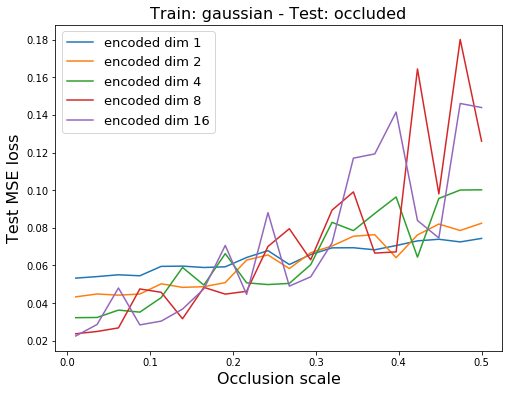

In [45]:
plt.figure(figsize=(8,6))
for i in range(len(GO_test_losses)):
    plt.plot(scales,GO_test_losses[i,:], label='encoded dim %d'%(2**i))
plt.legend(fontsize=13)
plt.xlabel("Occlusion scale", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: gaussian - Test: occluded", fontsize=16)
plt.show()

## Train: occulded - Test: gaussian

In [46]:
# define loss
loss_fn = nn.MSELoss()
# define values of sigma to be tested
sigmas = np.linspace(0.01,0.5,20)

OG_test_losses = []
for encoded_space_dim in encoded_space_dims:
    print("Testing encoded space dim: %d"%encoded_space_dim)
    gaussian_losses = []
        
    # init autoencoder
    net = Autoencoder(encoded_space_dim, best_model_dict['dropout'])
    # load trained weights
    net.load_state_dict(torch.load('params/occluded_net_params_'+str(encoded_space_dim)+'.pth', 
                                   map_location=torch.device('cpu')))
    
    for sigma in sigmas:
        print('\r'+"Testing gaussian noising with sigma %.3f"%sigma, end=' ')

        # define/update gaussian transform with new sigma
        gaussian_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x+np.random.normal(scale=sigma,size=x.shape)).float()),
        ])

        # load dataset and apply noise to it 
        gaussian_test_dataset = MNIST(data_root_dir, train=False, download=False, transform=gaussian_test_transform)
        # merge it with the original dataset that will be used as target
        gaussian_test_dataset = NoisyDataset(gaussian_test_dataset, test_dataset)
        # create test set loader to stream the data in batches to the net
        test_loader = DataLoader(gaussian_test_dataset, batch_size=512, shuffle=False)
        # compute the test loss
        gaussian_test_loss = test_denoisingAE(net, test_loader, nn.MSELoss())
        print('\r'+"Testing gaussian noising with sigma %.3f - loss : %.4f"%(sigma, gaussian_test_loss))
        gaussian_losses.append(gaussian_test_loss)
    OG_test_losses.append(gaussian_losses)
    
OG_test_losses = np.array(OG_test_losses)
np.save("Analysis_results/OG_losses", OG_test_losses)
np.save("Analysis_results/sigmas", sigmas)

Testing encoded space dim: 1
Testing gaussian noising with sigma 0.010 - loss : 0.0522
Testing gaussian noising with sigma 0.036 - loss : 0.0522
Testing gaussian noising with sigma 0.062 - loss : 0.0522
Testing gaussian noising with sigma 0.087 - loss : 0.0523
Testing gaussian noising with sigma 0.113 - loss : 0.0523
Testing gaussian noising with sigma 0.139 - loss : 0.0524
Testing gaussian noising with sigma 0.165 - loss : 0.0525
Testing gaussian noising with sigma 0.191 - loss : 0.0527
Testing gaussian noising with sigma 0.216 - loss : 0.0529
Testing gaussian noising with sigma 0.242 - loss : 0.0531
Testing gaussian noising with sigma 0.268 - loss : 0.0533
Testing gaussian noising with sigma 0.294 - loss : 0.0536
Testing gaussian noising with sigma 0.319 - loss : 0.0539
Testing gaussian noising with sigma 0.345 - loss : 0.0543
Testing gaussian noising with sigma 0.371 - loss : 0.0545
Testing gaussian noising with sigma 0.397 - loss : 0.0548
Testing gaussian noising with sigma 0.423 -

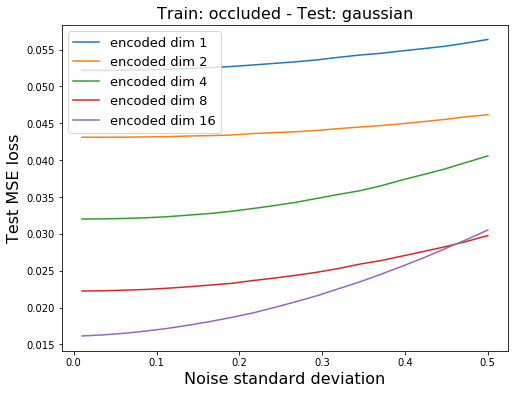

In [47]:
plt.figure(figsize=(8,6))
for i in range(len(OG_test_losses)):
    plt.plot(sigmas,OG_test_losses[i,:], label='encoded dim %d'%(2**i))
plt.legend(fontsize=13)
plt.xlabel("Noise standard deviation", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: occluded - Test: gaussian", fontsize=16)
plt.show()

## Train: occulded - Test: occluded

In [48]:
# define loss
loss_fn = nn.MSELoss()
# define values of sigma to be tested
scales = np.linspace(0.01,0.5,20)

OO_test_losses = []
for encoded_space_dim in encoded_space_dims:
    print("Testing encoded space dim: %d"%encoded_space_dim)
    occluded_losses = []
        
    # init autoencoder
    net = Autoencoder(encoded_space_dim, best_model_dict['dropout'])
    # load trained weights
    net.load_state_dict(torch.load('params/gaussian_net_params_'+str(encoded_space_dim)+'.pth', 
                                   map_location=torch.device('cpu')))
    
    for scale in scales:
        print('\r'+"Testing occlusion noise with scale %.3f"%scale, end=' ')

        # define/update gaussian transform with new sigma
        occluded_test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomErasing(p=1, scale=(scale, scale), ratio=(1,1), value=np.random.rand()),
        ])

        # load dataset and apply noise to it 
        occluded_test_dataset = MNIST(data_root_dir, train=False, download=False, transform=occluded_test_transform)
        # merge it with the original dataset that will be used as target
        occluded_test_dataset = NoisyDataset(occluded_test_dataset, test_dataset)
        # create test set loader to stream the data in batches to the net
        test_loader = DataLoader(occluded_test_dataset, batch_size=512, shuffle=False)
        # compute the test loss
        occluded_test_loss = test_denoisingAE(net, test_loader, nn.MSELoss())
        print('\r'+"Testing occlusion noise with scale %.3f - loss : %.4f"%(scale, occluded_test_loss))
        occluded_losses.append(occluded_test_loss)
    OO_test_losses.append(occluded_losses)
    
OO_test_losses = np.array(OO_test_losses)
np.save("Analysis_results/OO_losses", OO_test_losses)
np.save("Analysis_results/scales", scales)

Testing encoded space dim: 1
Testing occlusion noise with scale 0.010 - loss : 0.0534
Testing occlusion noise with scale 0.036 - loss : 0.0549
Testing occlusion noise with scale 0.062 - loss : 0.0553
Testing occlusion noise with scale 0.087 - loss : 0.0547
Testing occlusion noise with scale 0.113 - loss : 0.0597
Testing occlusion noise with scale 0.139 - loss : 0.0594
Testing occlusion noise with scale 0.165 - loss : 0.0565
Testing occlusion noise with scale 0.191 - loss : 0.0593
Testing occlusion noise with scale 0.216 - loss : 0.0611
Testing occlusion noise with scale 0.242 - loss : 0.0639
Testing occlusion noise with scale 0.268 - loss : 0.0660
Testing occlusion noise with scale 0.294 - loss : 0.0660
Testing occlusion noise with scale 0.319 - loss : 0.0672
Testing occlusion noise with scale 0.345 - loss : 0.0645
Testing occlusion noise with scale 0.371 - loss : 0.0713
Testing occlusion noise with scale 0.397 - loss : 0.0711
Testing occlusion noise with scale 0.423 - loss : 0.0697
Te

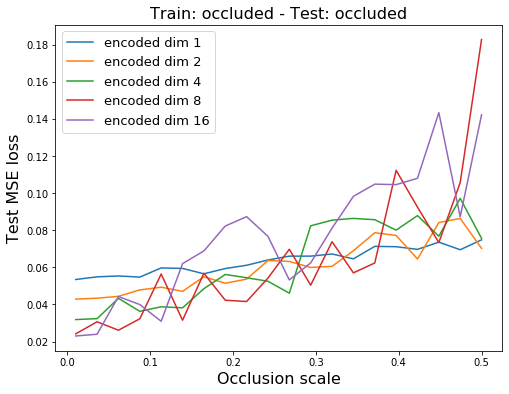

In [49]:
plt.figure(figsize=(8,6))
for i in range(len(OO_test_losses)):
    plt.plot(scales,OO_test_losses[i,:], label='encoded dim %d'%(2**i))
plt.legend(fontsize=13)
plt.xlabel("Occlusion scale", fontsize=16)
plt.ylabel("Test MSE loss", fontsize=16)
plt.title("Train: occluded - Test: occluded", fontsize=16)
plt.show()